<a href="https://colab.research.google.com/github/acastellanos-ie/NLP-MBD-EN2022A-Electives/blob/main/language_modelling/language%20modelling_elmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [ ]:
repository_name = "NLP-MBD-EN2022A-Electives"
repository_url = 'https://github.com/acastellanos-ie/' + repository_name

In [ ]:
! git clone $repository_url

Cloning into 'NLP-SAMBD-EN-2021'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 57 (delta 19), reused 48 (delta 15), pack-reused 0
Unpacking objects: 100% (57/57), done.


Install the requirements (be aware that it could take a while)

In [ ]:
! pip install -Uqqr $repository_name/requirements.txt

     |████████████████████████████████| 12.0 MB 1.3 MB/s 
     |████████████████████████████████| 3.4 MB 6.2 MB/s 
     |████████████████████████████████| 1.5 MB 43.8 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 432 kB 54.3 MB/s 
     |████████████████████████████████| 126 kB 65.1 MB/s 
     |████████████████████████████████| 10.4 MB 64.4 MB/s 
     |████████████████████████████████| 10.5 MB 44.1 MB/s 
     |████████████████████████████████| 24.8 MB 1.3 MB/s 
     |████████████████████████████████| 631 kB 50.5 MB/s 
     |████████████████████████████████| 385 kB 48.1 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:42tcmalloc: large alloc 1147494400 bytes == 0x563e381bc000 @  0x7f8f2f45e615 0x563dfe05b4cc 0x563dfe13b47a 0x563dfe05e2ed 0x563dfe14fe1d 0x563dfe0d1e99 0x563dfe0cc9ee 0x563dfe05fbda 0x563dfe0d1d00 0x563dfe0cc9ee 0x563dfe05fbda 0x563dfe0ce737 0x563dfe150c66 0x563dfe0cddaf 0x563dfe150c66 0x563dfe0

Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

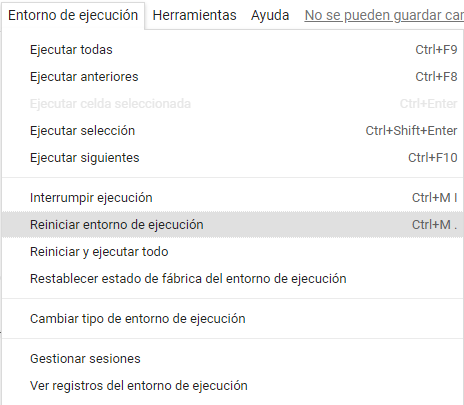

Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

# Language Modelling

In this notebook we are going to start playing with languages models. In particular, we are going to start with the simplest approach based on n-grams. Then, in the following threads, we will move to more advanced approaches based on LSTM and Transformer architectures.

The Natural Language Toolkit (NLTK) has data types and functions that make life easier for us when we want to count bigrams and compute their probabilities.

Let's start!

In [ ]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

**Import the Brown corpus**

For the experimentation, we are going to use the well-known Brown Corpus.

The Brown University Standard Corpus of Present-Day American Englis, or just Brown Corpus (https://en.wikipedia.org/wiki/Brown_Corpus),  is a general corpus containing 500 samples of English-language text, totaling roughly one million words, compiled from works published in the United States in 1961.



In [ ]:
from nltk.corpus import brown
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

From the words of the Brown corpus

In [ ]:
brown.words()

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

Let's inspect what are the most likely (most frequent) words in the dataset. The probability of a word is very important for our language model. When we ask the LM to generate new text, it should rely on these word probabilities, so it can generate words that are likely in our dataset.

We compute the word frequency by using the `FreqDist` function of NLTK (an nltk.FreqDist() is like a dictionary, but it is ordered by frequency).

The following uses this function to compute the freqs and plot the 20 most frequent words

In [ ]:
freq_brown = nltk.FreqDist(brown.words())

list(freq_brown.keys())[:20]
freq_brown.most_common(20)

[('the', 62713),
 (',', 58334),
 ('.', 49346),
 ('of', 36080),
 ('and', 27915),
 ('to', 25732),
 ('a', 21881),
 ('in', 19536),
 ('that', 10237),
 ('is', 10011),
 ('was', 9777),
 ('for', 8841),
 ('``', 8837),
 ("''", 8789),
 ('The', 7258),
 ('with', 7012),
 ('it', 6723),
 ('as', 6706),
 ('he', 6566),
 ('his', 6466)]

We can see that they are mostly stopwords, punctuation signs.

**Should we remove them? Why?** 

No, just think in what we are trying to do here. We are trying to use the dataset to create a model of the language to, given a set of words, predict the most probable next word. For this process, stopwords, as well as punctuation or other signs are need.

For the same reason, we shall not stemmize/lemmatize, neither normalize the words. We need all these variations to learn a proper language model (i.e, `the` != `The`)

## Bigram Model

We'll start small and we will create a language model based on bi-grams. This LM is rather simplistic: it will only codify relationships of length 2.

To that end, we will use the `ConditionalFreqDist` function of NLTK. `nltk.ConditionalFreqDist()` counts frequencies of pairs. When given a list of bigrams, it maps each first word of a bigram to a FreqDist over the second words of the bigram.

If you remember the theoretical session, we are applying the Markov assumption: the next element (word in our case) of a sequence can be predicted by just focusing on the previous one.

The following code creates these bi-gram counts.
If we print the `conditions` we can see the antecedent of the bi-grams. (`conditions()` in a `ConditionalFreqDist` are like `keys()` in a dictionary).

In [ ]:
cfreq_brown_2gram = nltk.ConditionalFreqDist(nltk.bigrams(brown.words()))
cfreq_brown_2gram.conditions()[:10]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of']

Let' see the most frequent terms after the word `my`.

In [ ]:
# the cfreq_brown_2gram entry for "my" is a FreqDist (i.e, a dictionary of word and freqCount).
my_terms = cfreq_brown_2gram["my"]

# Sort the terms by frequency and print the 25th most common
sorted(my_terms.items(), key=lambda x: -x[1])[:25]

[('own', 52),
 ('hand', 19),
 ('life', 19),
 ('mind', 19),
 ('first', 15),
 ('wife', 14),
 ('hands', 14),
 ('eyes', 13),
 ('father', 13),
 ('mother', 12),
 ('husband', 12),
 ('way', 12),
 ('head', 11),
 ('left', 8),
 ('heart', 7),
 ('point', 7),
 ('body', 7),
 ('Uncle', 7),
 ('best', 6),
 ('family', 6),
 ('right', 6),
 ('brother', 6),
 ('friends', 6),
 ('name', 6),
 ('business', 6)]

We can do the same with the `most_common` function

In [ ]:
cfreq_brown_2gram["my"].most_common(25)

[('own', 52),
 ('hand', 19),
 ('life', 19),
 ('mind', 19),
 ('first', 15),
 ('wife', 14),
 ('hands', 14),
 ('eyes', 13),
 ('father', 13),
 ('mother', 12),
 ('husband', 12),
 ('way', 12),
 ('head', 11),
 ('left', 8),
 ('heart', 7),
 ('point', 7),
 ('body', 7),
 ('Uncle', 7),
 ('best', 6),
 ('family', 6),
 ('right', 6),
 ('brother', 6),
 ('friends', 6),
 ('name', 6),
 ('business', 6)]

With the `nltk.ConditionalProbDist()`, map pairs are mapped to probabilities.

In [ ]:
cprob_brown_2gram = nltk.ConditionalProbDist(cfreq_brown_2gram, nltk.MLEProbDist) # Uses a Maximum Likelihood Estimation (MLE) estimator

This again has `conditions()` wihch are like dictionary keys

In [ ]:
cprob_brown_2gram.conditions()[:10]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of']

We can also find the words that can come after `my` by using the function `samples()`

In [ ]:
cprob_brown_2gram["my"].samples()

dict_keys(['political', 'client', 'fellow', 'man', 'candidacy', 'best', 'place-kicking', 'last', 'reflexes', 'jobs', 'family', 'thanks', 'firm', 'payroll', 'judgment', 'sales', 'first', 'mother', 'boys', 'share', 'daily', 'wife', 'legs', 'big', 'hands', 'biologist', 'locker', 'hand', 'right', 'neck', 'heart', 'grudge', 'neighbor', 'brother', 'house', 'good', 'life', 'native', 'charge-a-plate', "son's", 'psychiatrist', 'son', 'children', 'arms', 'daughter', 'opinion', 'husband', 'friends', 'country', 'wonderful', 'school', 'home', 'desire', 'point', 'little', 'part', 'two', 'itinerary', 'classroom', 'initial', 'induction', 'own', 'students', 'classes', 'personal', 'only', 'estimation', 'taste', 'objectivity', 'bed', 'eyes', 'principal', 'primary', 'Roman', 'experience', 'stay', 'lot', 'leave', 'learned', 'Bible', 'nearest', 'Father', 'Saviour', 'patient', 'peace', 'work', 'patients', 'professional', 'talents', 'soul', 'light', 'salvation', 'foes', 'flesh', 'fingers', 'body', 'finger', '

In addition, you can see the prob of a particular pair

In [ ]:
cprob_brown_2gram["my"].prob("own")

0.04478897502153316

In [ ]:
cprob_brown_2gram["my"].prob("leg")

0.0034453057708871662

## Compute the probability of a sentence

Create a function to compute the probability of a word from its frequency

In [ ]:
def unigram_prob(word):
    len_brown = len(brown.words())
    return float(freq_brown[word]) / float(len_brown)

unigram_prob("night")

0.0003427512418273636

We now can ask for the probability of a word sequence.

For instance: `P(how do you do) = P(how) * P(do|how) * P(you|do) * P(do | you)`

In [ ]:
unigram_prob("how") * cprob_brown_2gram["how"].prob("do") * cprob_brown_2gram["do"].prob("you") * cprob_brown_2gram["you"].prob("do")

1.5639033871961e-09

Compare it with the prob of another not so common sentence: `how do you dance`

In [ ]:
unigram_prob("how") * cprob_brown_2gram["how"].prob("do") * cprob_brown_2gram["do"].prob("you") * cprob_brown_2gram["you"].prob("dance")

1.0089699272232904e-10

As expected, one order of magnitude less probable

## Generate Language

With our bi-gram language model already generated, we can now use it to generate text and see what has our model learned.

In [ ]:
cprob_brown_2gram["my"].generate()

'bed'

Let's see if the model create valid text or just jiberish

In [ ]:
word = "my"
text = ""
for index in range(20):
    text += word + " "
    word = cprob_brown_2gram[ word].generate()
print(text)

my place us forever . Next to be so many listeners , and now one of the meaning greetings from 


It is not a valid sentence, but it has some kind of sense. 

Remember that we are just learning from bigrams!

**We can try another datasets to train a language models using different dataset.**

In particular we are going to import the book dataset of NLTK, which includes the text of different books.


The following function takes a text (i.e., the text o a given book) to learn a language model, and a initial word to start the generation and the number of words that have to be generated.

In [ ]:
# Here is how to do this with NLTK books:
nltk.download('gutenberg')
nltk.download('genesis')
nltk.download('inaugural')
nltk.download('nps_chat')
nltk.download('webtext')
nltk.download('treebank')

from nltk.book import *


def generate_text(text, initialword, numwords):
    bigrams = list(nltk.ngrams(text, 2))
    cpd = nltk.ConditionalProbDist(nltk.ConditionalFreqDist(bigrams), nltk.MLEProbDist)

    word = initialword
    text = ""
    for i in range(numwords):
        text += word + " "
        word = cpd[ word].generate() 

    print(text)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of

We use different books to generate text

In [ ]:
# Holy Grail
generate_text(text6, "I", 25)


I am Zoot ! MINSTREL : Patsy . Come on ! It is your mother ! Go away , as soon to make them an 


In [ ]:
# sense and sensibility
generate_text(text2, "I", 25)

# TriGrams

Let's try a more advance model using tri-grams to see if it is able to generate better language.

We cannot use the `ConditionalFreqDist` as before. `nltk.ConditionalFreqDist` expects its data as a sequence of `(condition, item)` tuples. `nltk.trigrams` returns tuples of length 3. Therefore, we have to adapt the trigrams output.

In [ ]:
def generate_text(text, initialword, numwords):
    trigrams = list(nltk.ngrams(text, 3,  pad_right=True, pad_left=True))
    trigram_pairs = (((w0, w1), w2) for w0, w1, w2 in trigrams) # Adapt the format to use ConditionalFreqDist
    cpd = nltk.ConditionalProbDist(nltk.ConditionalFreqDist(trigram_pairs), nltk.MLEProbDist)

    word = initialword
    text = ""
    for i in range(numwords):
        w = cpd[(word[i],word[i+1])].generate() 
        word += [w]
    
    print(" ".join(word))

In [ ]:
generate_text(text2, ["I", "am"], 25)

I am so sorry we cannot stay here long , and put on a twilight walk to the bustle , and of whose success he was affected


As expected, it creates a better lm.

Can we go on with more n-grams? Let's see

# N-grams

We are going to update again the `generate_text` function to create a language model based on 4-grams.


In [ ]:
def generate_text(text, initialword, numwords):
    ngrams = list(nltk.ngrams(text, 4,  pad_right=True, pad_left=True))
    ngram_pairs = (((w0, w1, w2), w3) for w0, w1, w2, w3 in ngrams)
    cpd = nltk.ConditionalProbDist(nltk.ConditionalFreqDist(ngram_pairs), nltk.MLEProbDist)

    word = initialword
    text = ""
    for i in range(numwords):
        w = cpd[(word[i],word[i+1], word[i+2])].generate() 
        word += [w]
    
    print(" ".join(word))

In [ ]:
generate_text(text2, ["I", "am", "very"], 25)

I am very sure that Colonel Brandon has not the smallest chance . As soon , however , towards that unfortunate girl -- I must say it ,


As we make the n-grams larger we got more accurate language models. However, as explained in class, if we create large n-grams we are not going to have enough data to train our models: we will never see enough data (enough sequences of n-grams) to train the model.

As an exercise, I leave up to you to keep extending this LM model to 5-gram, 6-gram....
